## Librerias
Primero se declaran las librerias, es importante configurar el path caffe_root para cada PC

In [1]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import sys
caffe_root = '/home/lex/caffe-master/'  # CONFIGURAR PARA CADA PC!!
sys.path.append("/home/lex/caffe-master/python")

import caffe # Importa la libreria CAFFE

## Archivos Prototxt

Siempre que se vaya a entrenar usando CAFFE son necesarios 3 archivos:

<ul>
    <li> Archivo de entrenamiento que contiene la estructura de la red y las direcciones a los archivos de entrenamiento.
    <li> Archivo solver, contiene los parametros del entrenamiento como tipo de solver (e.g SGD, ADAGRAD, etc), learning reate, etc.
    <li> Archivo deploy, contiene la arquitectura de la red solamente, es usado para evaluar la red.
    
</ul>

Exite una forma de crear estos archivos a traves de ipython, la siguiente seccion de codigo crea el archivo de entrenamiento:


In [16]:
from caffe import layers as L
from caffe import params as P

# Esta funcionThe version of the notebook server is 4.0.4 and is running on:
# el numero de imagenes procesadas por lote
def lenet(lmdb, batch_size):
    
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
# Ahora escribimos los archivos prototxt, diciendoles donde van a quedar los archivos
with open('/home/lex/2_SISTEMIC/9_Deep_Learning/3_Arquitecturas/Arq_1/python/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('/home/lex/caffe-master/examples/mnist/mnist_train_lmdb', 64)))
    
with open('/home/lex/2_SISTEMIC/9_Deep_Learning/3_Arquitecturas/Arq_1/python/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('/home/lex/caffe-master/examples/mnist/mnist_test_lmdb', 100)))
    

Una vez hechos los archivos .prototxt se pueden visualizar facilmente en ipython con:
<code>
    !cat /home/lex/2_SISTEMIC/9_Deep_Learning/3_Arquitecturas/Arq_1/Arc_1_train_val.prototxt
    !cat /home/lex/2_SISTEMIC/9_Deep_Learning/3_Arquitecturas/Arq_1/Arc_1_solver.prototxt
</code>

## Configuración del modelo 

Primero debemos configurar nuestro PC, en caso de todo estar instalado de forma correcta podemos sin problemas elegir si entrenar con GPU o CPU, en este caso lo haremos con GPU a traves de las siguentes lineas

In [17]:
# Configuramos el hardware que usaremos para entrenar
caffe.set_device(0)
caffe.set_mode_gpu()

En este caso usaremos un solver tipo Stocastic gradient descent(SGD)

In [18]:
# Elegimos el tipo de solver para la red
solver = caffe.SGDSolver('/home/lex/2_SISTEMIC/9_Deep_Learning/3_Arquitecturas/Arq_1/Arc_1_solver.prototxt')

## Entrenamiento

En ipython podemos tener control de cada iteración que damos en el SGD lo cual nos permite grabar un log que nos informara como fue el entrenamiento, en la siguiente seccion de codigo se seleccionan parametros y entrena la red

In [22]:
%%time 
niter = 200 # el SGD solo realizara 200 iteraciones
test_interval = 25 # probaremos el conjunto de prueba cada 25 iteraciones

# Aqui se crean las estructuras para alojar los datos de entrenamiento
train_loss = np.zeros(niter) # guarda loss
test_acc = np.zeros(int(np.ceil(niter / test_interval))) # guarda accuracy
#gtalkoutput = np.np.ax2.set_ylabel('test accuracy')zeros((niter, 8, 10)) # guarda salida de la red

# Main loop entrenamiento
for it in range(niter):
    solver.step(1)  # Se ejecuta q vez el SGD
    
    # guarda loss
    train_loss[it] = solver.net.blobs['loss'].data
    
   
    # Para correr  pruebas cada 25 iteraciones lo configuramos aca, CAFFE puede 
    # configurarse para hacerlo automaticamente si se desea.
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 4.9 s, sys: 932 ms, total: 5.84 s
Wall time: 5.04 s


Ahora podemos visualozar los datos de entrenamiento con el siguiente codigo

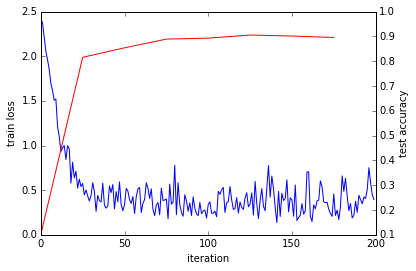

In [23]:
#Imprimimos el train error y el test accuracy
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')lo realiza